# Projet 5 - Catégorisez automatiquement des questions

## Importation des librairies et des données

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn import decomposition
from nltk.tokenize import word_tokenize
pd.options.mode.chained_assignment = None  # default='warn'
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk import *
import csv

In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [4]:
print('Taille de la base train:', train.shape)
print('Taille de la base test:', test.shape)

Taille de la base train: (204432, 9)
Taille de la base test: (51109, 9)


In [5]:
train.head()

,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0


In [6]:
min(list(train['AnswerCount']))

0.0

## Nettoyage des données

In [7]:
# Le jeu de données étant trop grand pour certaines étapes, nous avons commencé par diviser le jeu de données train et test par 2
train_df = train.sample(frac=0.25)
test_df = test.sample(frac=0.25)

In [87]:
print('Taille de la base train:', train_df.shape)
print('Taille de la base test:', test_df.shape)

Taille de la base train: (51107, 10)
Taille de la base test: (12777, 10)


In [9]:
train_df.dropna(subset=['Title'], inplace = True)

Première phase du nettoyage des tags et des questions:
Pour les tags:
- Suppression des caractères spéciaux 

Pour les questions:
- Jointure du titre et du corps pour le traiter comme un seul élément
- Suppression des balises html
- Ajout des retours à la ligne

In [10]:
train_df['Body'] = train_df['Title'] + ' ' + train_df['Body']
test_df['Body'] = test_df['Title'] + ' ' + test_df['Body']

In [11]:
train_df['processed_tags'] = train_df['Tags'].str.findall("<(.*?)>")
test_df['processed_tags'] = test_df['Tags'].str.findall("<(.*?)>")
train_df['Body'] = train_df['Body'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
test_df['Body'] = test_df['Body'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
train_df['Body'] = train_df['Body'].map(lambda x: x.replace('\n', ' '))
test_df['Body'] = test_df['Body'].map(lambda x: x.replace('\n', ' '))
train_df = train_df.drop(['Tags', 'Title'], axis = 1)
test_df = test_df.drop(['Tags', 'Title'], axis = 1)

### Définition des fonctions de nettoyage

Deuxième phase de nettoyage sur les questions uniquement par les fonctions suivantes:
- Tokenisation
- Suppression des stopwords
- Lemmatisation

La 1ère fonction tokenise la phrase, supprime les caractères spéciaux, les chiffres et la ponctuation, et passe toutes les lettres en minuscule.
La 2ème fonction reprend la liste des stopwords anglais et supprime ces mots de la phrase
La 3ème fonction est simplement une lemmatisation

#### Fonctions

In [12]:
def tokenization(sentence):
    token = RegexpTokenizer(r'[a-zA-Z]+')
    return token.tokenize(sentence.lower())

stop_words = set(stopwords.words('english'))
def clean_stopwords(sentence):
    return [word for word in sentence if not word in stop_words]

lemmatizer = WordNetLemmatizer()
def lemmatisation(sentence):
    return [lemmatizer.lemmatize(word) for word in sentence]

#### Appliction sur un exemple

In [13]:
example_sentence = 'Hello, these are 3 examples to show the different steps of the cleaning process.'

In [14]:
tok_sentence = tokenization(example_sentence)
clean_sentence = clean_stopwords(tok_sentence)
lemm_sentence = lemmatisation(clean_sentence)

In [15]:
print('Phrase originale: ', example_sentence, '\n')
print('Phrase tokenisée, en minuscules et sans ponctuation:', tok_sentence, '\n')
print('Phrase sans les stop words: ', clean_sentence, '\n')
print('Phrase lemmatisée: ', lemm_sentence)

Phrase originale:  Hello, these are 3 examples to show the different steps of the cleaning process. 

Phrase tokenisée, en minuscules et sans ponctuation: ['hello', 'these', 'are', 'examples', 'to', 'show', 'the', 'different', 'steps', 'of', 'the', 'cleaning', 'process'] 

Phrase sans les stop words:  ['hello', 'examples', 'show', 'different', 'steps', 'cleaning', 'process'] 

Phrase lemmatisée:  ['hello', 'example', 'show', 'different', 'step', 'cleaning', 'process']


#### Application sur le jeu de données

In [16]:
train_df['processed_body'] = train_df['Body'].map(lambda x: tokenization(x))
test_df['processed_body'] = test_df['Body'].map(lambda x: tokenization(x))
train_df['processed_body'] = train_df['processed_body'].map(lambda x: clean_stopwords(x))
test_df['processed_body'] = test_df['processed_body'].map(lambda x: clean_stopwords(x))
train_df['processed_body'] = train_df['processed_body'].map(lambda x: lemmatisation(x))
test_df['processed_body'] = test_df['processed_body'].map(lambda x: lemmatisation(x))
train_df['processed_body_2'] = train_df['processed_body'].map(lambda x: clean_stopwords(x))
test_df['processed_body_2'] = test_df['processed_body'].map(lambda x: clean_stopwords(x))

## Nettoyage des tags

Le nettoyage des tags consiste à trier les tags par ordre de popularité, c'est à dire des plus utilisés aux moins utilisés, puis séLectionner les premiers n tags les plus populaires. Dans ce projet, n=20.

### Suppression de tags 

In [17]:
#full_df = pd.concat([train_df,test_df])

In [18]:
#full_df.shape

In [19]:
tags_count = pd.Series([item for sublist in train_df['processed_tags'].tolist() for item in sublist]).value_counts()
n_top_tags = 20
tags_filter = train_df['processed_tags'].map(lambda x: any(elem in x for elem in tags_count[:n_top_tags].index.tolist()))
filtered_df = train_df[tags_filter]
filtered_df.shape

(34805, 10)

In [39]:
tags_count

0        4729
1        4390
2        4326
3        4096
4        3779
         ... 
11670       1
11671       1
11672       1
11673       1
11674       1
Length: 11675, dtype: int64

In [30]:
tags_count_df

,tags_count
java,4729
javascript,4390
python,4326
c#,4096
android,3779
...,...
ddos,1
osx-gatekeeper,1
gotw,1
html-head,1


In [37]:
tags_count_df = tags_count.to_frame(name='tags_count')
tags_count_df.to_csv('tags_count.csv', sep = ';')

In [41]:
tags_filter_test = test_df['processed_tags'].map(lambda x: any(elem in x for elem in tags_count[:n_top_tags].index.tolist()))
filtered_test_df = test_df[tags_filter_test]

In [42]:
#full_filtered_df = pd.concat([filtered_df, filtered_test_df])
#full_filtered_df.shape

### Fréquence des tags

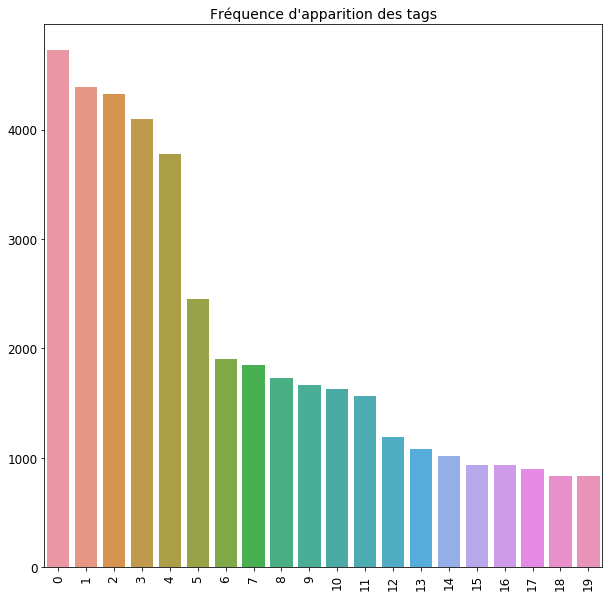

In [43]:
plt.figure(figsize=(10,10))
sns.barplot(x = tags_count[:20].index , y = tags_count[:20])
plt.title('Fréquence d\'apparition des tags', fontsize = 14)
plt.xticks(label = 'Tags', rotation = 90, fontsize = 12)
plt.yticks(label = 'Nombre d\'apparition', fontsize = 12);

## Fréquence des termes

On souhaite connaitre la fréquence ces termes utilisés dans les questions. Cela permet d'agrandir la liste des stopwords et donc d'être plus efficace. Ainsi les termes gardés pour l'analyse seront plus cohérents avec le thème de la question. On trie les termes par fréquence et on pose une limite, ici de 500. Tous les mots apparaissant moins fw_dic 500 fois sont ajoutés à la liste de stopwords et supprimés de la question. On obtient deux éléments à la fin de cette étape :
- "stop_words": un set qui contient les stopwords de base anglais ainsi que les termes peu fréquents.
- "fw_dict": un dictionnaire qui contient tous les termes les plus utiliés ainsi que le nombre d'utilisation correspondant.

In [44]:
body_list = filtered_df['processed_body'].tolist()

In [45]:
fw_counts = Counter([elt for lst in body_list for elt in lst])
fw_common_words = [word[0] for word in fw_counts.most_common(25)]
fw_common_counts = [word[1] for word in fw_counts.most_common(25)]

In [46]:
fw_words_total = [word[0] for word in fw_counts.most_common()]
fw_counts_total = [word[1] for word in fw_counts.most_common()]

In [47]:
fw_counts_number = pd.Series(fw_counts_total)

In [48]:
len(fw_counts_number)

87801

In [49]:
limite = 500
print('Limite fixée: ', limite)

Limite fixée:  500


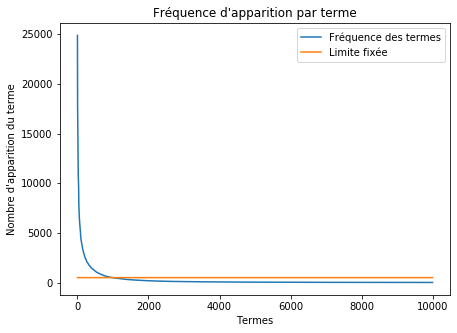

In [50]:
plt.figure(figsize=(7,5))
plt.plot(range(10000), fw_counts_number.iloc[0:10000], label='Fréquence des termes')
plt.plot(range(10000), [limite]*10000, label = 'Limite fixée')
plt.xlabel('Termes')
plt.ylabel('Nombre d\'apparition du terme')
plt.title('Fréquence d\'apparition par terme')
plt.legend();

### Suppressions des termes les moins fréquents

In [86]:
len(stop_words)

86969

In [51]:
stop_words = set(stopwords.words('english'))
fw_dict = dict(fw_counts)

In [52]:
fw_dict = dict(fw_counts)
del_words = []
for key, value in fw_dict.items():
    if value <= limite:
        stop_words.add(key) # Ajoute les nouveaux stopwords à la liste précédente
        del_words.append(key)
[fw_dict.pop(key) for key in del_words] # Supprime les nouveaux stopwords du dictionnaire

[386,
 437,
 335,
 28,
 357,
 3,
 79,
 8,
 302,
 90,
 41,
 24,
 469,
 489,
 15,
 40,
 477,
 284,
 68,
 232,
 20,
 9,
 28,
 4,
 51,
 336,
 140,
 186,
 48,
 63,
 83,
 6,
 69,
 461,
 15,
 2,
 2,
 319,
 407,
 184,
 125,
 64,
 22,
 70,
 97,
 66,
 210,
 70,
 306,
 20,
 47,
 148,
 48,
 411,
 389,
 88,
 228,
 5,
 445,
 7,
 142,
 68,
 35,
 5,
 24,
 244,
 159,
 122,
 19,
 23,
 282,
 57,
 264,
 108,
 1,
 145,
 184,
 1,
 1,
 16,
 14,
 61,
 126,
 248,
 258,
 316,
 107,
 8,
 24,
 2,
 413,
 311,
 487,
 284,
 103,
 323,
 41,
 291,
 172,
 14,
 279,
 230,
 375,
 430,
 15,
 380,
 10,
 30,
 218,
 136,
 437,
 122,
 145,
 6,
 127,
 262,
 66,
 47,
 371,
 115,
 388,
 94,
 20,
 347,
 12,
 1,
 4,
 2,
 3,
 11,
 42,
 29,
 428,
 203,
 38,
 284,
 319,
 50,
 3,
 413,
 86,
 491,
 138,
 337,
 110,
 466,
 21,
 248,
 23,
 115,
 9,
 270,
 369,
 282,
 103,
 110,
 1,
 4,
 67,
 478,
 7,
 266,
 470,
 8,
 487,
 9,
 3,
 3,
 15,
 8,
 16,
 236,
 13,
 86,
 24,
 148,
 11,
 202,
 4,
 41,
 422,
 22,
 18,
 48,
 91,
 78,
 170,
 77,
 2

In [53]:
# Ordonne par ordre alphabétique et affiche fréquence du mot
sorted(fw_dict.items(), key=lambda t: t[0])

[('able', 2602),
 ('abstract', 505),
 ('accept', 590),
 ('access', 2726),
 ('according', 538),
 ('account', 776),
 ('achieve', 809),
 ('across', 655),
 ('action', 2463),
 ('active', 825),
 ('activity', 2730),
 ('activitythread', 968),
 ('actual', 793),
 ('actually', 1456),
 ('add', 6375),
 ('added', 1550),
 ('adding', 1183),
 ('address', 1468),
 ('admin', 545),
 ('advance', 721),
 ('ajax', 1188),
 ('alert', 1029),
 ('algorithm', 505),
 ('align', 547),
 ('allow', 1021),
 ('already', 2105),
 ('also', 5127),
 ('alternative', 589),
 ('always', 1625),
 ('amount', 506),
 ('android', 24888),
 ('androidruntime', 1017),
 ('angular', 830),
 ('animation', 842),
 ('annotation', 790),
 ('another', 2854),
 ('answer', 2722),
 ('anyone', 2492),
 ('anything', 1476),
 ('apache', 1944),
 ('api', 3389),
 ('apk', 905),
 ('app', 10376),
 ('appear', 596),
 ('appears', 704),
 ('append', 933),
 ('apple', 934),
 ('application', 6525),
 ('apply', 902),
 ('appreciated', 837),
 ('approach', 992),
 ('apps', 677),
 

In [54]:
fw_dict

{'execute': 1619,
 'command': 2977,
 'android': 24888,
 'trying': 5181,
 'application': 6525,
 'find': 5307,
 'google': 3358,
 'play': 912,
 'app': 10376,
 'write': 2727,
 'enter': 578,
 'time': 7504,
 'limit': 687,
 'start': 3319,
 'screen': 1595,
 'using': 17772,
 'new': 15461,
 'function': 13521,
 'try': 3725,
 'code': 16210,
 'java': 18398,
 'process': 2486,
 'runtime': 1571,
 'work': 9686,
 'file': 18815,
 'created': 2129,
 'running': 2792,
 'device': 1938,
 'installed': 1338,
 'problem': 5998,
 'solve': 757,
 'cannot': 2419,
 'switch': 825,
 'python': 7792,
 'would': 10343,
 'like': 15543,
 'use': 14242,
 'following': 6553,
 'install': 2402,
 'however': 3864,
 'version': 5985,
 'global': 922,
 'system': 6626,
 'set': 8365,
 'user': 10641,
 'understand': 2034,
 'happens': 753,
 'information': 1575,
 'directory': 2194,
 'usr': 1574,
 'bin': 1252,
 'thank': 606,
 'advance': 721,
 'wait': 618,
 'v': 6440,
 'extension': 1190,
 'previous': 622,
 'question': 5704,
 'mode': 1116,
 'linux

### Word cloud

In [55]:
wordcloud = WordCloud(stopwords=stop_words).generate_from_frequencies(fw_counts)

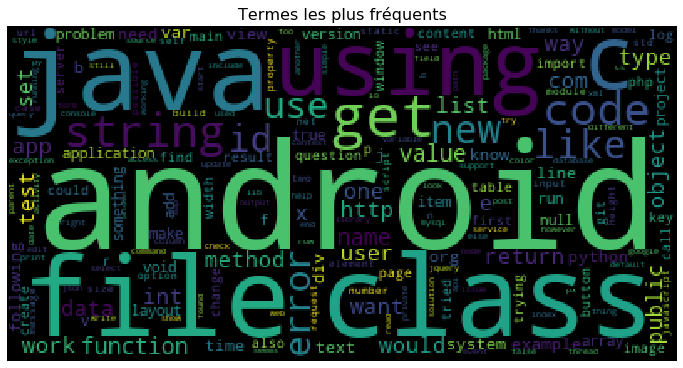

In [56]:
plt.figure(figsize = (12,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Termes les plus fréquents', fontsize = 16);

## Tf-idf

On souhaite créer une matrice contenant les différents termes des questions, ainsi que leur importance par rapport à l'ensemble des questions. La valeur attribuée à chaque terme est donc son poids c'est à dire: 

__poids = fréquence du terme × idf (terme)__ 

avec idf étant l'inverse de la proportion de questions qui contient le terme. 

### CountVectorizer

In [46]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        token = RegexpTokenizer(r'[a-zA-Z]+')
        return [self.wnl.lemmatize(t) for t in token.tokenize(doc.lower()) if t not in stop_words]
wnl = WordNetLemmatizer()    
tokenizer = lambda x: [wnl.lemmatize(x) for x in token.tokenize(x.lower()) if x not in stop_words]
    
    
count = CountVectorizer(tokenizer=LemmaTokenizer(),
                        stop_words=stop_words, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

On applique cette pipeline sur l'intégralité des questions, préalablement cleanées, avant de tranformer ces données en matrice.

In [47]:
pipe.fit(filtered_df["Body"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words={'a', 'aa', 'aaa', 'aaaa', 'aaaaa',
                                             'aaaaaa', 'aaaaaaa', 'aaaaaaaa',
                                             'aaaaaaaaaaaa', 'aaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaa...
                                             'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
                                             'aaaaaaaaaaaaaaaaaap',
                                             'aaaaaaaaa

In [48]:
train_feature = pipe.transform(filtered_df["Body"])
train_feature

<34874x996 sparse matrix of type '<class 'numpy.float64'>'
	with 1061945 stored elements in Compressed Sparse Row format>

In [49]:
feature_names = count.get_feature_names()

In [50]:
len(feature_names)

996

In [51]:
feature_names

['able',
 'accept',
 'access',
 'according',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'activitythread',
 'actual',
 'actually',
 'add',
 'added',
 'adding',
 'address',
 'admin',
 'advance',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'allowed',
 'already',
 'also',
 'alternative',
 'always',
 'android',
 'androidruntime',
 'angular',
 'animation',
 'annotation',
 'another',
 'answer',
 'anyone',
 'anything',
 'apache',
 'api',
 'apk',
 'app',
 'appear',
 'appears',
 'append',
 'apple',
 'application',
 'apply',
 'appreciated',
 'approach',
 'apps',
 'area',
 'arg',
 'args',
 'argument',
 'around',
 'array',
 'arraylist',
 'article',
 'artifactid',
 'asp',
 'assembly',
 'assert',
 'assume',
 'async',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authentication',
 'auto',
 'automatically',
 'available',
 'avoid',
 'await',
 'b',
 'back',
 'background',
 'bad',
 'bar',
 'base',
 'based',
 'basic',
 'basically',
 'bean',
 'begin',
 'behavi

In [52]:
test_feature = pipe.transform(filtered_test_df["Body"])

In [57]:
test_feature

<8878x996 sparse matrix of type '<class 'numpy.float64'>'
	with 266150 stored elements in Compressed Sparse Row format>

In [53]:
# Matrice train et test contenant les termes et leur poids.
train_mx =  pd.DataFrame(train_feature.toarray(), columns = feature_names)
test_mx = pd.DataFrame(test_feature.toarray(), columns = feature_names)

In [43]:
test_mx.head()

,able,accept,access,according,account,achieve,across,action,active,activity,...,xcode,xml,xmlns,year,yes,yet,z,zero,zip,zygoteinit
0,0.010169,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.013161,0.0,0.000000,0.01654,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.015352,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015575,0.0,0.000000,0.00000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.012778,0.00000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0


## Exportation des données

Exportation de tous les éléments à utiliser dans l'analyse ou l'API

In [44]:
test_mx.to_csv('test_mx.csv', sep=';')
train_mx.to_csv('train_mx.csv', sep=';')

In [74]:
filtered_df['Body'].to_csv('filtered_df.csv', sep = ';', header='Question')

In [47]:
#csv_columns = ['Key','Value']
with open('fw_dict.csv', 'w') as f: 
    w = csv.DictWriter(f, fw_dict.keys())
    w.writeheader()
    w.writerow(fw_dict)

In [48]:
with open('feature_name.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in feature_names:
        writer.writerow([val])

In [61]:
L_SW = list(stop_words)

In [64]:
with open('list_stop_words.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in L_SW:
        writer.writerow([val])